## Observations
1. Our gradient estimates at known sample locations are large due to samples from our multioutput surrogate

In [1]:
using LinearAlgebra
using Plots

In [2]:
include("../rollout.jl")
include("../testfns.jl")

TestLinearCosine1D (generic function with 3 methods)

In [3]:
function sample_random_matrix(xmin, xmax, d, n)
    matrix = zeros(d, n)
    for i in 1:d
        for j in 1:n
            matrix[i, j] = xmin + (xmax - xmin) * rand()
        end
    end
    return matrix
end

sample_random_matrix (generic function with 1 method)

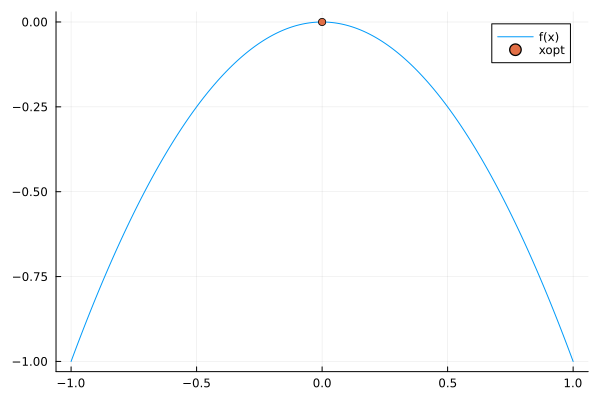

In [4]:
testfn = TestQuadratic1D(-1., 0., 0.)
tplot(testfn)

In [5]:
n, h, σn2 = 1, 0, 1e-6
MC_SAMPLES = 25
# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, h+1);
rns = randn(MC_SAMPLES, testfn.dim+1, h+1);

MAX_BUDGET, MAX_TRIALS = 25, 1
xmin, xmax, d = (testfn.bounds[1], testfn.bounds[2], size(testfn.bounds, 1))
θ = [.25]
ψ = kernel_scale(
    kernel_matern52,
    [1., θ...]
)
# ψ = kernel_matern52(θ)

lbs, ubs = [xmin], [xmax]
ϵ, num_starts = 1e-6, 4
s = SobolSeq(lbs, ubs)

xstarts = reduce(hcat, next!(s) for i = 1:num_starts)
xstarts = hcat(xstarts, lbs .+ ϵ)
xstarts = hcat(xstarts, ubs .- ϵ);

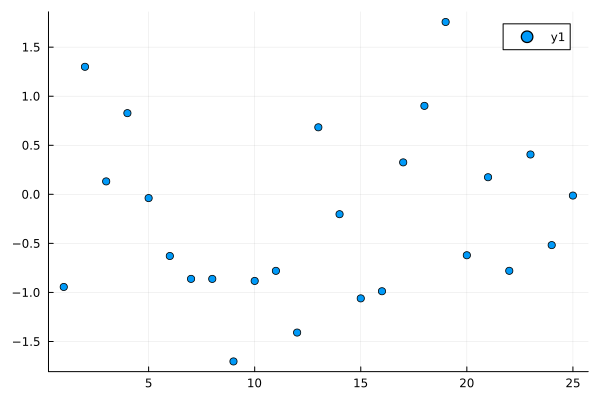

In [19]:
scatter(rns[:, 1:1, :][:])

### Dense Experiments in 1D for Rollout Acquisition Functions
We'll do a comparative analysis, visually, of the structure of the rollout acquisition function in 1D for horizons 0 and 1.

In [7]:
X = [-.5;; .75;;]
X = collect(-1:.25:1.)
X = reshape(X, 1, length(X))
δX = rand(size(X)...)
y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
∇y = [testfn.∇f(X[:,j]) for j in 1:size(X, 2)]
sur = fit_surrogate(ψ, X, y; σn2=σn2)
domain = xmin:.01:xmax
ex = zeros(length(domain))
stdx = zeros(length(domain))
dex = zeros(length(domain))
dstdx = zeros(length(domain))
αxs, ∇αxs = zeros(MC_SAMPLES), zeros(MC_SAMPLES)

Ts = []
print("Beginning Experiment\nProgress Bar: ")
for (i, x) in enumerate(domain)
    print("|")
    x0 = [x]

    # Rollout Trajectory
    for j in 1:MC_SAMPLES
        T = Trajectory(Base.deepcopy(sur), x0, h)
        rollout!(T, lbs, ubs; xstarts=xstarts, rnstream=rns[j,:,:])
        αxs[j] = α(T)
        ∇αxs[j] = first(∇α(T))
    end

    sx = sur(x0)
    μ = sum(αxs) / MC_SAMPLES
    dμ = sum(∇αxs) / MC_SAMPLES
    ex[i] = μ + sx.EI
    dex[i] = dμ # + first(sx.∇EI)
    stdx[i] = sqrt(sum((αxs .- μ) .^ 2) / (MC_SAMPLES - 1))
    dstdx[i] = sqrt(sum((∇αxs .- dμ) .^ 2) / (MC_SAMPLES - 1))
end

Beginning Experiment
Progress Bar: |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

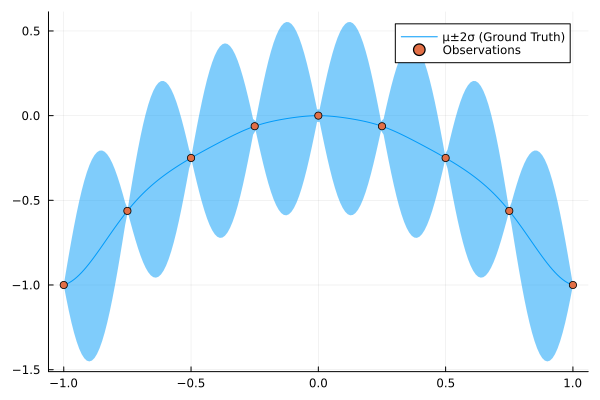

In [11]:
plot1D(sur; xmin=-1., xmax=1., npts=200)

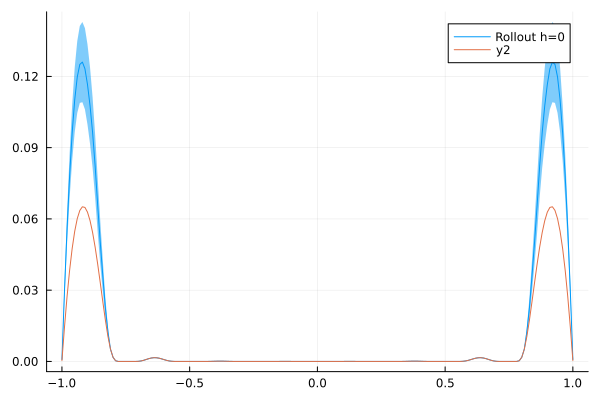

In [9]:
plot(
    domain,
    ex,
    label="Rollout h=$h",
    ribbons=stdx / sqrt(MC_SAMPLES)
)
plot!(domain, [sur([x]).EI for x in domain])

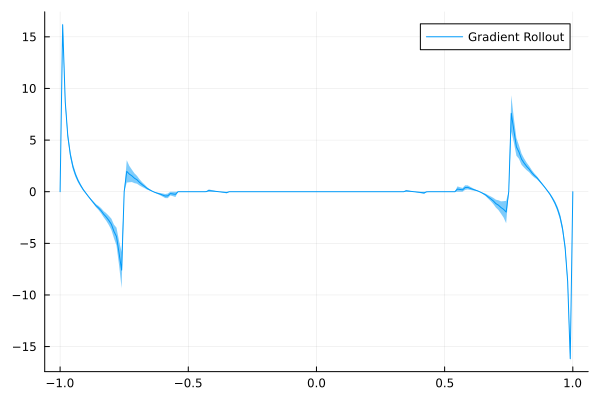

In [167]:
# plot(domain, [first(sur([x]).∇EI) for x in domain])
plot(
    domain,
    dex,
    label="Gradient Rollout",
    ribbons=dstdx / sqrt(MC_SAMPLES)
)

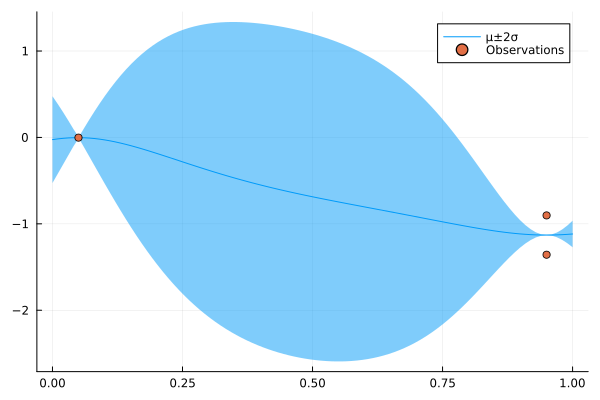

In [142]:
plot1D(Ts[50].mfs; xmin=0., xmax=1.)

In [147]:
Ts[50].mfs.y

3-element Vector{Float64}:
  0.7515942044399511
 -0.14840579556004885
 -0.6031884088799023

In [90]:
v = 0.

for i in 1:25
    v += first(sample(Ts[i])[1].∇y)
end

v /= 25

1.0277582051728669

In [143]:
T = Trajectory(sur, [.95], 0);

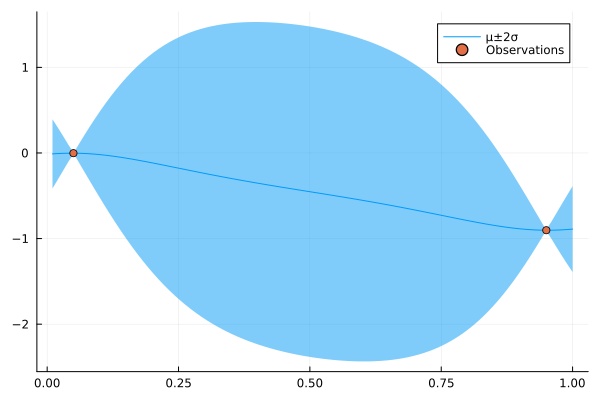

In [144]:
plot1D(T.mfs; xmin=0., xmax=1.)

In [145]:
function gp_draw(s::MultiOutputFantasyRBFsurrogate, x::Vector{Float64}; stdnormal::Vector{Float64})
    sx = s(x)
    f_and_∇f =  sx.μ + sx.σ .* stdnormal
    println("Predictive Mean: $(sx.μ)")
    println("Predictive Variance: $(sx.σ)")
    f, ∇f = f_and_∇f[1], f_and_∇f[2:end]
    return f, ∇f
end

gp_draw(T.mfs, [.95]; stdnormal=randn(1))

Predictive Mean: [-0.9024995455551001, -0.03150144394789658]
Predictive Variance: [0.000999999500080825, 5.16351248237407]


(-0.9036471432579586, [-5.957139469741146])

In [99]:
eval_mixed_KxX(T.mfs, [.95])

2×4 Matrix{Float64}:
  0.00978194  1.0  0.967986  -1.23381
 -0.0693185   0.0  1.23381   21.2661

In [100]:
eval_Dk(T.mfs.ψ, zeros(d); D=d)

2×2 Matrix{Float64}:
 1.0  -0.0
 0.0  26.6667